<a href="https://colab.research.google.com/github/RanaDarpan/Crop-Health-Prediction/blob/main/Crop_Yield_Prediction_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rice Yield Prediction: Phase-Based Mapping & Advanced Augmentation**
#
# **Objective**: Build a high-accuracy rice yield prediction model using district-level weather data
#
# **Key Challenges Addressed**:
# - Limited sample size (district-level data)
# - Yield mapping problem (yield is only known at season end)
# - Weather impact varies by crop growth stage
# - Need for data augmentation without creating unrealistic samples
#
# **Solution Highlights**:
# 1. Phase-based weather mapping (vegetative, reproductive, ripening)
# 2. Multiple augmentation techniques (Mixup, Bootstrap, VAE)
# 3. Comprehensive model comparison (XGBoost, Transformers, etc.)
# 4. Feature importance analysis for agricultural insights


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import NearestNeighbors
import os

In [51]:
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
warnings.filterwarnings('ignore')
print("✅ Libraries imported successfully")

✅ Libraries imported successfully


# ## 1. Data Loading & Initial Exploration
#
# Let's first load and understand our dataset structure.

In [52]:
# LOAD THE RICE DATASET
# Note: In Colab, you'll need to upload your rice.xlsx file first
# from google.colab import files
# uploaded = files.upload()

# For local testing (comment out in Colab)
df = pd.read_excel('rice.xlsx')

# Display basic information
print("📊 Dataset Overview:")
print(f"Total records: {len(df)}")
print(f"Number of districts: {df['District'].nunique()}")
print(f"Years covered: {df['Year'].min()} - {df['Year'].max()}")
print(f"Seasons: {df['Season'].unique()}")
print(f"Weather features: {len([col for col in df.columns if col not in ['District', 'Season', 'Year', 'Yield (Ton./Ha.)']])}")

# Check for missing values
missing = df.isnull().sum()
print("\n🔍 Missing Values Check:")
print(missing[missing > 0])

# Display sample data
print("\n📋 Sample Data (First 2 records):")
print(df.head(2).T)  # Transposed for better readability

📊 Dataset Overview:
Total records: 2670
Number of districts: 6
Years covered: 2013 - 2023
Seasons: ['Kharif' 'Summer']
Weather features: 24

🔍 Missing Values Check:
Series([], dtype: int64)

📋 Sample Data (First 2 records):
                                        0            1
District                          Bharuch      Bharuch
Season                             Kharif       Kharif
Crop                                 Rice         Rice
Year                                 2013         2013
duration                        2013-2014    2013-2014
Area ( in Hectare)                  11260        11260
Production ( in Tonnes)             15672        15672
Yield (Ton./Ha.)                     1.39         1.39
Total duration of weeks (SMW)       22-44        22-44
week                                   22           23
tempmax                              40.1         36.0
tempmin                              27.9         25.1
temp                            31.914286    29.528571
dew   

# ## 2. Phase-Based Data Preparation (CRITICAL STEP)
#
# **Why this matters**: Rice yield is most sensitive to weather during specific growth stages:
# - 🌱 **Vegetative phase** (0-30% of season): Early growth, sensitive to temperature
# - 💐 **Reproductive phase** (30-60% of season): Flowering, EXTREMELY sensitive to heat stress
# - 🌾 **Ripening phase** (60-100% of season): Grain filling, sensitive to sunshine & moisture
#
# Simply averaging weather across the whole season dilutes these critical signals!

In [53]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd


def prepare_phase_based_data(df):
    """
    Advanced Rice Phase-Based Feature Engineering
    Designed to improve ML performance significantly
    """

    print("🔄 Starting advanced phase-based data preparation...")

    # --------------------------------------------------
    # STEP 1: Parse Duration
    # --------------------------------------------------
    def parse_duration(duration_str):
        if pd.isna(duration_str):
            return None, None
        parts = str(duration_str).split('-')
        if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
            return int(parts[0]), int(parts[1])
        return None, None

    df[['start_week', 'end_week']] = df['duration'].apply(
        lambda x: pd.Series(parse_duration(x))
    )

    # --------------------------------------------------
    # STEP 2: Calculate Season Progress
    # --------------------------------------------------
    def calculate_relative_week(row):
        start, end, week = row['start_week'], row['end_week'], row['week']
        if start is None or end is None or pd.isna(week):
            return None

        if end < start:  # year crossover
            total_weeks = (52 - start) + end + 1
            relative = (week - start) if week >= start else (52 - start + week)
        else:
            total_weeks = end - start + 1
            relative = week - start

        return relative / total_weeks if total_weeks > 0 else None

    df['season_progress'] = df.apply(calculate_relative_week, axis=1)

    # --------------------------------------------------
    # STEP 3: Assign Rice Growth Phases
    # --------------------------------------------------
    def assign_phase(progress):
        if progress is None:
            return None
        if progress < 0.3:
            return 'Vegetative'
        elif progress < 0.6:
            return 'Reproductive'
        else:
            return 'Ripening'

    df['growth_phase'] = df['season_progress'].apply(assign_phase)

    # --------------------------------------------------
    # STEP 4: Aggregate by Season
    # --------------------------------------------------
    season_groups = df.groupby(['District', 'Season', 'Year'])

    phase_records = []

    print(f"⚙️ Processing {len(season_groups)} seasons...")

    for (district, season, year), group in season_groups:

        record = {
            "District": district,
            "Season": season,
            "Year": year,
            "Yield": group['Yield (Ton./Ha.)'].iloc[0],
            "Area": group['Area ( in Hectare)'].iloc[0],
            "Production": group['Production ( in Tonnes)'].iloc[0]
        }

        for phase in ['Vegetative', 'Reproductive', 'Ripening']:

            phase_data = group[group['growth_phase'] == phase]

            if len(phase_data) == 0:
                continue

            # -------------------------
            # Core Weather Stats
            # -------------------------
            record[f'{phase}_temp_mean'] = phase_data['temp'].mean()
            record[f'{phase}_temp_std'] = phase_data['temp'].std()
            record[f'{phase}_precip_total'] = phase_data['precip'].sum()
            record[f'{phase}_rain_days'] = (phase_data['precip'] > 0).sum()
            record[f'{phase}_solar_total'] = phase_data['solarenergy'].sum()
            record[f'{phase}_humidity_mean'] = phase_data['humidity'].mean()

            # -------------------------
            # Stress Intensity Features (Improved)
            # -------------------------
            heat_days = (phase_data['tempmax'] > 35).sum()
            cool_days = (phase_data['tempmin'] < 18).sum()

            record[f'{phase}_heat_stress_ratio'] = heat_days / len(phase_data)
            record[f'{phase}_cool_stress_ratio'] = cool_days / len(phase_data)

            # -------------------------
            # Growing Degree Days (CRITICAL)
            # -------------------------
            base_temp = 10
            gdd = np.maximum(phase_data['temp'] - base_temp, 0).sum()
            record[f'{phase}_GDD'] = gdd

            # -------------------------
            # Rainfall Stability
            # -------------------------
            record[f'{phase}_precip_std'] = phase_data['precip'].std()

        phase_records.append(record)

    phase_df = pd.DataFrame(phase_records)

    # --------------------------------------------------
    # STEP 5: Advanced Derived Features
    # --------------------------------------------------

    # Reproductive stress importance (most important phase)
    if 'Reproductive_heat_stress_ratio' in phase_df.columns:
        phase_df['Reproductive_stress_index'] = (
            phase_df['Reproductive_heat_stress_ratio'] * 0.7 +
            phase_df.get('Reproductive_cool_stress_ratio', 0) * 0.3
        )

    # Total seasonal GDD
    gdd_cols = [col for col in phase_df.columns if '_GDD' in col]
    phase_df['Total_GDD'] = phase_df[gdd_cols].sum(axis=1)

    # Water stress index
    dry_cols = [col for col in phase_df.columns if 'precip_total' in col]
    phase_df['Total_Precip'] = phase_df[dry_cols].sum(axis=1)

    # Solar efficiency
    if 'Reproductive_solar_total' in phase_df.columns:
        phase_df['Solar_efficiency'] = (
            phase_df['Reproductive_solar_total'] /
            (phase_df['Total_Precip'] + 1)
        )

    # --------------------------------------------------
    # STEP 6: Encode Categorical Variables
    # --------------------------------------------------
    phase_df['Season_Encoded'] = phase_df['Season'].map({
        'Kharif': 0,
        'Summer': 1
    })

    phase_df['District_Encoded'] = LabelEncoder().fit_transform(
        phase_df['District']
    )

    phase_df['Year_Numeric'] = (
        phase_df['Year'].astype(int) -
        phase_df['Year'].astype(int).min()
    )

    print(f"✅ Advanced phase data ready: {phase_df.shape}")

    return phase_df


# Run
phase_df = prepare_phase_based_data(df)
phase_df.to_csv("improved_phase_based_rice_data.csv", index=False)

🔄 Starting advanced phase-based data preparation...
⚙️ Processing 115 seasons...
✅ Advanced phase data ready: (115, 21)


# ## 3. Data Visualization: Understanding Phase-Based Features
#
# Let's visualize how weather varies across growth phases and impacts yield

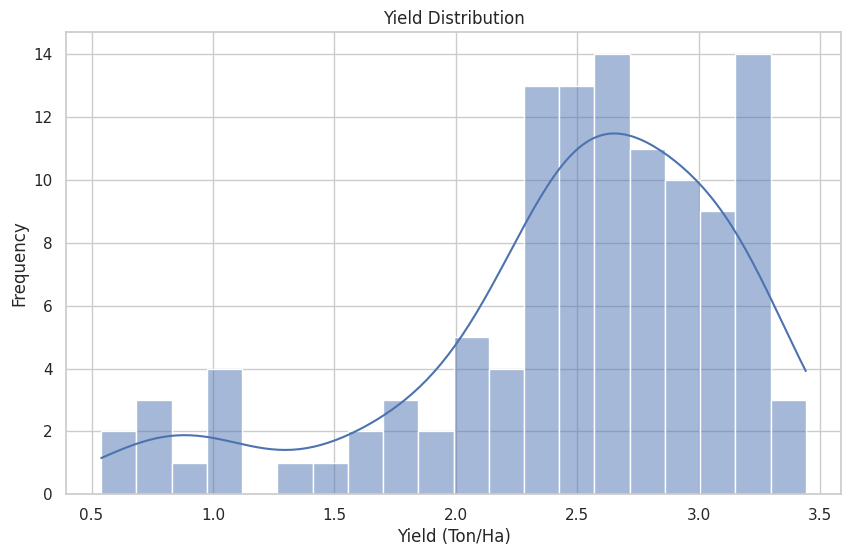

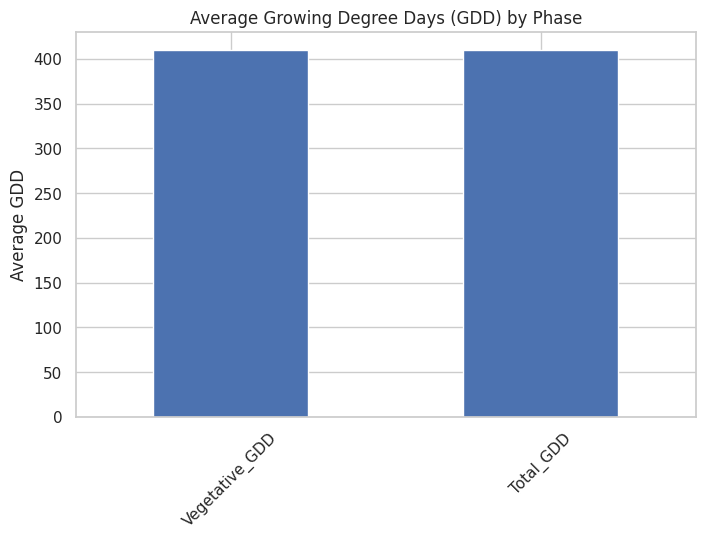

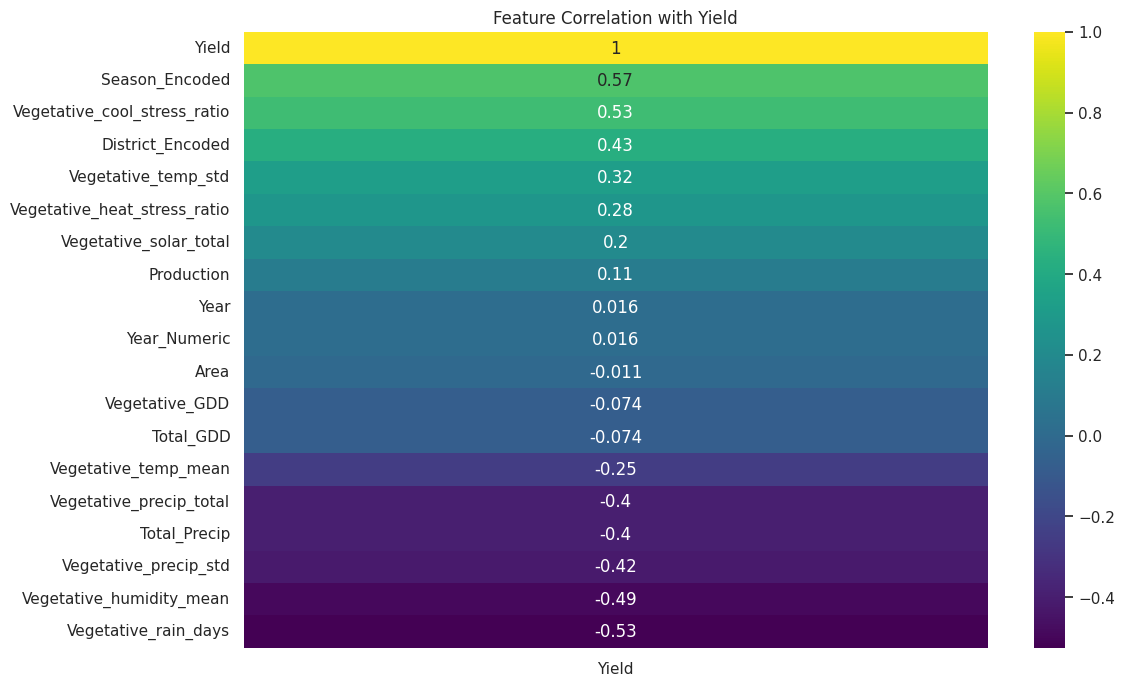

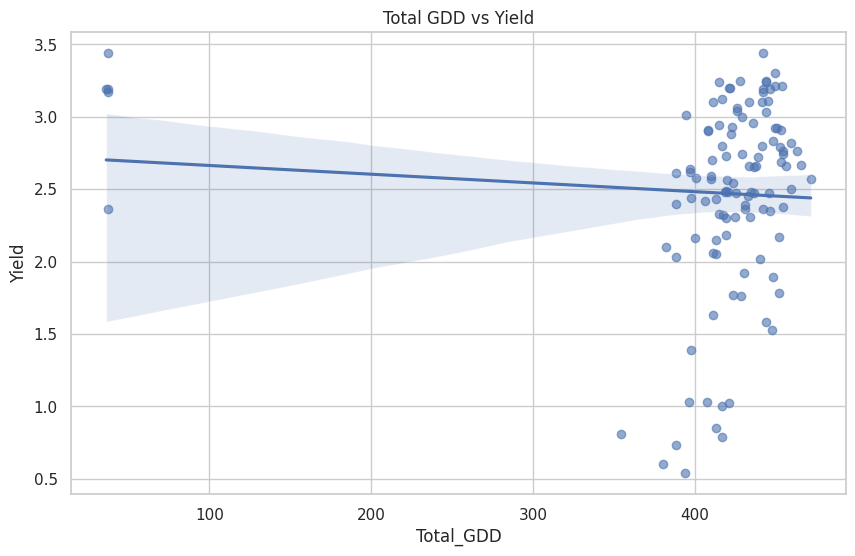

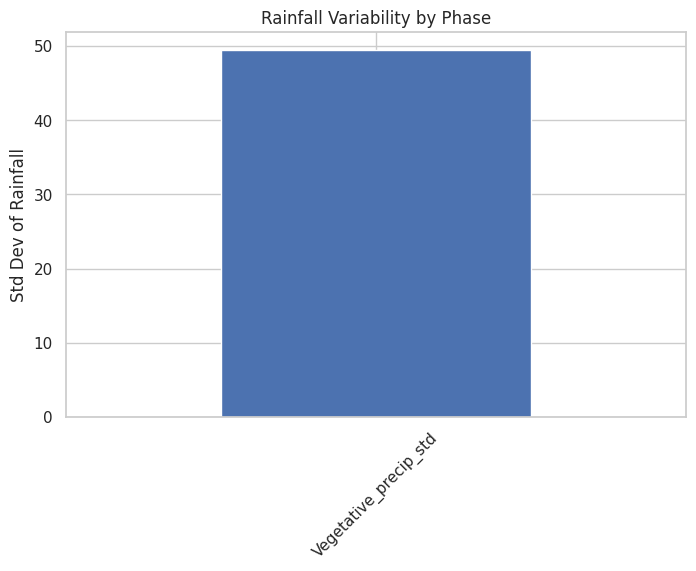

📊 All visualizations generated successfully!


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# --------------------------------------------------
# 1️⃣ Yield Distribution
# --------------------------------------------------
plt.figure()
sns.histplot(phase_df["Yield"], kde=True, bins=20)
plt.title("Yield Distribution")
plt.xlabel("Yield (Ton/Ha)")
plt.ylabel("Frequency")
plt.show()


# --------------------------------------------------
# 2️⃣ Phase-wise GDD Comparison
# --------------------------------------------------
gdd_cols = [col for col in phase_df.columns if "_GDD" in col]

plt.figure(figsize=(8, 5))
phase_df[gdd_cols].mean().plot(kind="bar")
plt.title("Average Growing Degree Days (GDD) by Phase")
plt.ylabel("Average GDD")
plt.xticks(rotation=45)
plt.show()


# --------------------------------------------------
# 3️⃣ Correlation Heatmap (Top Features)
# --------------------------------------------------
plt.figure(figsize=(12, 8))

corr_matrix = phase_df.corr(numeric_only=True)

# Show only correlations with Yield
yield_corr = corr_matrix[["Yield"]].sort_values(
    by="Yield", ascending=False
)

sns.heatmap(yield_corr, annot=True, cmap="viridis")
plt.title("Feature Correlation with Yield")
plt.show()


# --------------------------------------------------
# 4️⃣ Reproductive Stress vs Yield
# --------------------------------------------------
if "Reproductive_stress_index" in phase_df.columns:
    plt.figure()
    sns.scatterplot(
        x="Reproductive_stress_index",
        y="Yield",
        data=phase_df
    )
    plt.title("Reproductive Stress vs Yield")
    plt.show()


# --------------------------------------------------
# 5️⃣ Total GDD vs Yield
# --------------------------------------------------
if "Total_GDD" in phase_df.columns:
    plt.figure()
    sns.regplot(
        x="Total_GDD",
        y="Yield",
        data=phase_df,
        scatter_kws={"alpha": 0.6}
    )
    plt.title("Total GDD vs Yield")
    plt.show()


# --------------------------------------------------
# 6️⃣ Phase-wise Rainfall Stability
# --------------------------------------------------
precip_std_cols = [col for col in phase_df.columns if "precip_std" in col]

if len(precip_std_cols) > 0:
    plt.figure(figsize=(8, 5))
    phase_df[precip_std_cols].mean().plot(kind="bar")
    plt.title("Rainfall Variability by Phase")
    plt.ylabel("Std Dev of Rainfall")
    plt.xticks(rotation=45)
    plt.show()


print("📊 All visualizations generated successfully!")

# ## 4. Advanced Data Augmentation Techniques
#
# **Why augment?** Our dataset is small (district-level), so we need more samples.
#
# **Important**: We'll try multiple methods and compare which works best:
#
# 1. **Bootstrap**: Adds small noise to real samples (low risk)
# 2. **Mixup**: Blends two real samples (medium risk, often best for regression)
# 3. **SMOTE**: Creates samples near existing ones (medium risk)
# 4. **VAE**: Generative model (higher risk, but powerful if done right)

In [55]:
# ==============================
# REQUIRED IMPORTS
# ==============================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors


# ==============================
# ADVANCED DATA AUGMENTER
# ==============================
class AdvancedDataAugmenter:

    def __init__(self, random_state=42):
        np.random.seed(random_state)
        tf.random.set_seed(random_state)
        self.scaler = StandardScaler()
        self.feature_cols = None
        print("✅ Initialized data augmenter")

    # --------------------------------------------------
    # DATA PREPARATION (Leakage Safe)
    # --------------------------------------------------
    def prepare_data_for_augmentation(self, df):

        target_col = 'Yield'

        # Columns to exclude
        id_cols = [
            'District', 'Season', 'Year',
            'District_Encoded'
        ]

        # Leakage columns (VERY IMPORTANT)
        leakage_cols = ['Area', 'Production']

        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

        self.feature_cols = [
            col for col in numeric_cols
            if col != target_col and col not in id_cols
        ]

        X = df[self.feature_cols].copy()
        y = df[target_col].copy()

        # Remove leakage columns if present
        X = X.drop(columns=[c for c in leakage_cols if c in X.columns],
                   errors='ignore')

        self.feature_cols = X.columns.tolist()

        # Remove fully-null columns
        null_columns = X.columns[X.isna().all()].tolist()
        if len(null_columns) > 0:
            print(f"⚠️ Removing fully-null columns: {null_columns}")
            X = X.drop(columns=null_columns)
            self.feature_cols = X.columns.tolist()

        # Impute remaining NaNs
        if X.isna().any().any():
            print("⚠️ Applying KNN Imputer...")
            imputer = KNNImputer(n_neighbors=5)
            X = pd.DataFrame(
                imputer.fit_transform(X),
                columns=X.columns,
                index=X.index
            )

        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        print(f"Prepared {len(X)} samples with {X.shape[1]} features")

        return X_scaled, y.values


    # --------------------------------------------------
    # BOOTSTRAP
    # --------------------------------------------------
    def bootstrap_augmentation(self, X, y, n_samples=100):
        idx = np.random.choice(len(X), n_samples, replace=True)
        return X[idx], y[idx]


    # --------------------------------------------------
    # MIXUP
    # --------------------------------------------------
    def mixup_augmentation(self, X, y, n_samples=100, alpha=0.2):
        X_aug, y_aug = [], []
        for _ in range(n_samples):
            i, j = np.random.choice(len(X), 2, replace=False)
            lam = np.random.beta(alpha, alpha)
            X_new = lam * X[i] + (1 - lam) * X[j]
            y_new = lam * y[i] + (1 - lam) * y[j]
            X_aug.append(X_new)
            y_aug.append(y_new)
        return np.array(X_aug), np.array(y_aug)


    # --------------------------------------------------
    # SMOTE (Regression)
    # --------------------------------------------------
    def smote_regression(self, X, y, n_samples=100, k_neighbors=3):

        nn = NearestNeighbors(n_neighbors=k_neighbors + 1)
        nn.fit(X)
        _, indices = nn.kneighbors(X)

        X_aug, y_aug = [], []

        for _ in range(n_samples):
            idx = np.random.randint(0, len(X))
            neighbor_idx = indices[idx, np.random.randint(1, k_neighbors + 1)]
            alpha = np.random.uniform(0.2, 0.8)

            X_new = alpha * X[idx] + (1 - alpha) * X[neighbor_idx]
            y_new = alpha * y[idx] + (1 - alpha) * y[neighbor_idx]

            X_aug.append(X_new)
            y_aug.append(y_new)

        return np.array(X_aug), np.array(y_aug)


    # ==================================================
    # BASIC VAE (Optimized for Small Dataset)
    # ==================================================
    def basic_vae_augmentation(self, X, y, n_samples=100, latent_dim=8):

        input_dim = X.shape[1]

        inputs = keras.Input(shape=(input_dim,))
        h = layers.Dense(32, activation="relu")(inputs)
        z_mean = layers.Dense(latent_dim)(h)
        z_log_var = layers.Dense(latent_dim)(h)

        def sampling(args):
            z_mean, z_log_var = args
            epsilon = tf.random.normal(shape=tf.shape(z_mean))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        z = layers.Lambda(sampling)([z_mean, z_log_var])
        encoder = keras.Model(inputs, [z_mean, z_log_var, z])

        latent_inputs = keras.Input(shape=(latent_dim,))
        h_dec = layers.Dense(32, activation="relu")(latent_inputs)
        outputs = layers.Dense(input_dim)(h_dec)
        decoder = keras.Model(latent_inputs, outputs)

        class VAE(keras.Model):
            def __init__(self, encoder, decoder):
                super().__init__()
                self.encoder = encoder
                self.decoder = decoder

            def train_step(self, data):
                x = data[0] if isinstance(data, tuple) else data

                with tf.GradientTape() as tape:
                    z_mean, z_log_var, z = self.encoder(x)
                    reconstruction = self.decoder(z)

                    recon_loss = tf.reduce_mean(
                        tf.reduce_sum(tf.square(x - reconstruction), axis=1)
                    )

                    kl_loss = -0.5 * tf.reduce_mean(
                        tf.reduce_sum(
                            1 + z_log_var - tf.square(z_mean)
                            - tf.exp(z_log_var), axis=1
                        )
                    )

                    total_loss = recon_loss + kl_loss

                grads = tape.gradient(total_loss,
                                      self.trainable_weights)
                self.optimizer.apply_gradients(
                    zip(grads, self.trainable_weights)
                )
                return {"loss": total_loss}

        vae = VAE(encoder, decoder)
        vae.compile(optimizer="adam")

        # Reduced epochs for stability
        vae.fit(X, epochs=60, batch_size=16, verbose=0)

        z_samples = np.random.normal(0, 1, (n_samples, latent_dim))
        X_aug = decoder.predict(z_samples, verbose=0)

        # Small regressor for yield prediction
        reg = keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(1)
        ])
        reg.compile(optimizer="adam", loss="mse")
        reg.fit(X, y, epochs=40, verbose=0)

        y_aug = reg.predict(X_aug, verbose=0).flatten()

        return X_aug, y_aug


    # --------------------------------------------------
    # GENERATE DATASETS
    # --------------------------------------------------
    def generate_augmented_datasets(self, df, n_samples=100):

        print("\n🔄 Generating augmented datasets...\n")

        X_scaled, y = self.prepare_data_for_augmentation(df)

        datasets = {
            "Original": (X_scaled, y),
            "Bootstrap": self.bootstrap_augmentation(X_scaled, y, n_samples),
            "Mixup": self.mixup_augmentation(X_scaled, y, n_samples),
            "SMOTE": self.smote_regression(X_scaled, y, n_samples),
        }

        if len(X_scaled) > 20:
            datasets["Basic_VAE"] = self.basic_vae_augmentation(
                X_scaled, y, n_samples
            )

        print("✅ Augmentation complete!\n")
        return datasets


    # --------------------------------------------------
    # CREATE DATAFRAMES
    # --------------------------------------------------
    def create_augmented_dataframes(self, df, n_samples=100):

        datasets = self.generate_augmented_datasets(df, n_samples)
        dataframes = {}

        for name, (X_aug, y_aug) in datasets.items():
            X_original = self.scaler.inverse_transform(X_aug)

            df_aug = pd.DataFrame(
                X_original,
                columns=self.feature_cols
            )
            df_aug["Yield"] = y_aug
            df_aug["Augmentation_Method"] = name

            dataframes[name] = df_aug

        return dataframes


# ==============================
# USAGE
# ==============================

augmenter = AdvancedDataAugmenter()

augmented_dfs = augmenter.create_augmented_dataframes(
    phase_df,
    n_samples=100
)

print("\n📊 Dataset Summary:")
for name, df_aug in augmented_dfs.items():
    print(f"{name}: {len(df_aug)} samples")

✅ Initialized data augmenter

🔄 Generating augmented datasets...

Prepared 115 samples with 14 features
✅ Augmentation complete!


📊 Dataset Summary:
Original: 115 samples
Bootstrap: 100 samples
Mixup: 100 samples
SMOTE: 100 samples
Basic_VAE: 100 samples


# ## 5. Model Training & Comparison
#
# Let's compare multiple models across all augmentation methods:
#
# - ✅ **XGBoost**: Often best for tabular data like this
# - ✅ **Random Forest**: Robust, handles non-linearities well
# - ✅ **LightGBM**: Faster alternative to XGBoost
# - ✅ **Stacking**: Combines multiple models
# - ✅ **Transformer**: Tests if deep learning helps

In [56]:
# ==============================
# REQUIRED IMPORTS
# ==============================
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# ==============================
# OPTIMIZED MODEL EVALUATOR
# ==============================
class ModelEvaluator:

    def __init__(self, random_state=42, fast_mode=True):
        """
        fast_mode=True  → Faster experimentation
        fast_mode=False → Research-level full training
        """
        self.random_state = random_state
        self.fast_mode = fast_mode
        self.models = self.create_models()
        print("✅ Initialized model evaluator with",
              len(self.models), "models")

    # --------------------------------------------------
    # CREATE MODELS (Optimized)
    # --------------------------------------------------
    def create_models(self):

        if self.fast_mode:
            n_estimators = 100
            splits = 3
        else:
            n_estimators = 200
            splits = 5

        self.cv_splits = splits

        return {
            'XGBoost': xgb.XGBRegressor(
                n_estimators=n_estimators,
                max_depth=5,
                learning_rate=0.08,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=self.random_state
            ),

            'RandomForest': RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=8,
                min_samples_split=5,
                random_state=self.random_state,
                n_jobs=-1
            ),

            'LightGBM': lgb.LGBMRegressor(
                n_estimators=n_estimators,
                max_depth=5,
                learning_rate=0.08,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=self.random_state
            ),

            'Transformer': self.create_transformer_model
        }

    # --------------------------------------------------
    # LIGHTWEIGHT TRANSFORMER
    # --------------------------------------------------
    def create_transformer_model(self, input_dim):

        inputs = keras.Input(shape=(input_dim,))
        x = layers.Reshape((1, input_dim))(inputs)

        attention = layers.MultiHeadAttention(
            num_heads=2,
            key_dim=max(1, input_dim // 2)
        )(x, x)

        x = layers.LayerNormalization()(x + attention)

        ffn = layers.Dense(32, activation='relu')(x)
        ffn = layers.Dense(input_dim)(ffn)

        x = layers.LayerNormalization()(x + ffn)

        x = layers.Flatten()(x)
        outputs = layers.Dense(1)(x)

        model = keras.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='mse')

        return model

    # --------------------------------------------------
    # TIME SERIES CROSS VALIDATION
    # --------------------------------------------------
    def time_series_cv(self, X, y, model):

        tscv = TimeSeriesSplit(n_splits=self.cv_splits)

        r2_scores = []
        rmse_scores = []
        mae_scores = []

        for train_idx, test_idx in tscv.split(X):

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            if callable(model):  # Transformer

                tf_model = model(X_train.shape[1])

                epochs = 20 if self.fast_mode else 50

                tf_model.fit(
                    X_train, y_train,
                    epochs=epochs,
                    batch_size=16,
                    verbose=0
                )

                y_pred = tf_model.predict(X_test,
                                          verbose=0).flatten()
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            r2_scores.append(r2_score(y_test, y_pred))
            rmse_scores.append(
                np.sqrt(mean_squared_error(y_test, y_pred))
            )
            mae_scores.append(
                mean_absolute_error(y_test, y_pred)
            )

        return {
            "r2_mean": np.mean(r2_scores),
            "r2_std": np.std(r2_scores),
            "rmse_mean": np.mean(rmse_scores),
            "mae_mean": np.mean(mae_scores)
        }

    # --------------------------------------------------
    # EVALUATE ALL AUGMENTATIONS
    # --------------------------------------------------
    def evaluate_all(self, augmented_dfs):

        results = []

        for aug_method, df_aug in augmented_dfs.items():

            print(f"\n🔍 Evaluating: {aug_method}")

            feature_cols = [
                col for col in df_aug.columns
                if col not in ['Yield', 'Augmentation_Method']
            ]

            X = df_aug[feature_cols].values
            y = df_aug['Yield'].values

            for model_name, model in self.models.items():

                print(f"  🧪 Training {model_name}")

                try:
                    metrics = self.time_series_cv(X, y, model)

                    results.append({
                        "Augmentation": aug_method,
                        "Model": model_name,
                        "R2": metrics["r2_mean"],
                        "R2_std": metrics["r2_std"],
                        "RMSE": metrics["rmse_mean"],
                        "MAE": metrics["mae_mean"]
                    })

                except Exception as e:
                    print(f"  ❌ {model_name} failed:", e)

        return pd.DataFrame(results)


# ==============================
# RUN EVALUATION
# ==============================

# fast_mode=True → faster
# fast_mode=False → full training
evaluator = ModelEvaluator(fast_mode=True)

print("\n🚀 Starting evaluation...")
results_df = evaluator.evaluate_all(augmented_dfs)

print("\n🏆 Model Comparison:")
print(results_df.sort_values("R2",
                             ascending=False).to_string(index=False))

results_df.to_csv("model_comparison_results.csv", index=False)

print("\n💾 Results saved to model_comparison_results.csv")

✅ Initialized model evaluator with 4 models

🚀 Starting evaluation...

🔍 Evaluating: Original
  🧪 Training XGBoost
  🧪 Training RandomForest
  🧪 Training LightGBM
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 1.787097
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped t

# ## 6. Results Visualization & Interpretation


📊 Improved model performance visualization saved as 'model_performance.png'


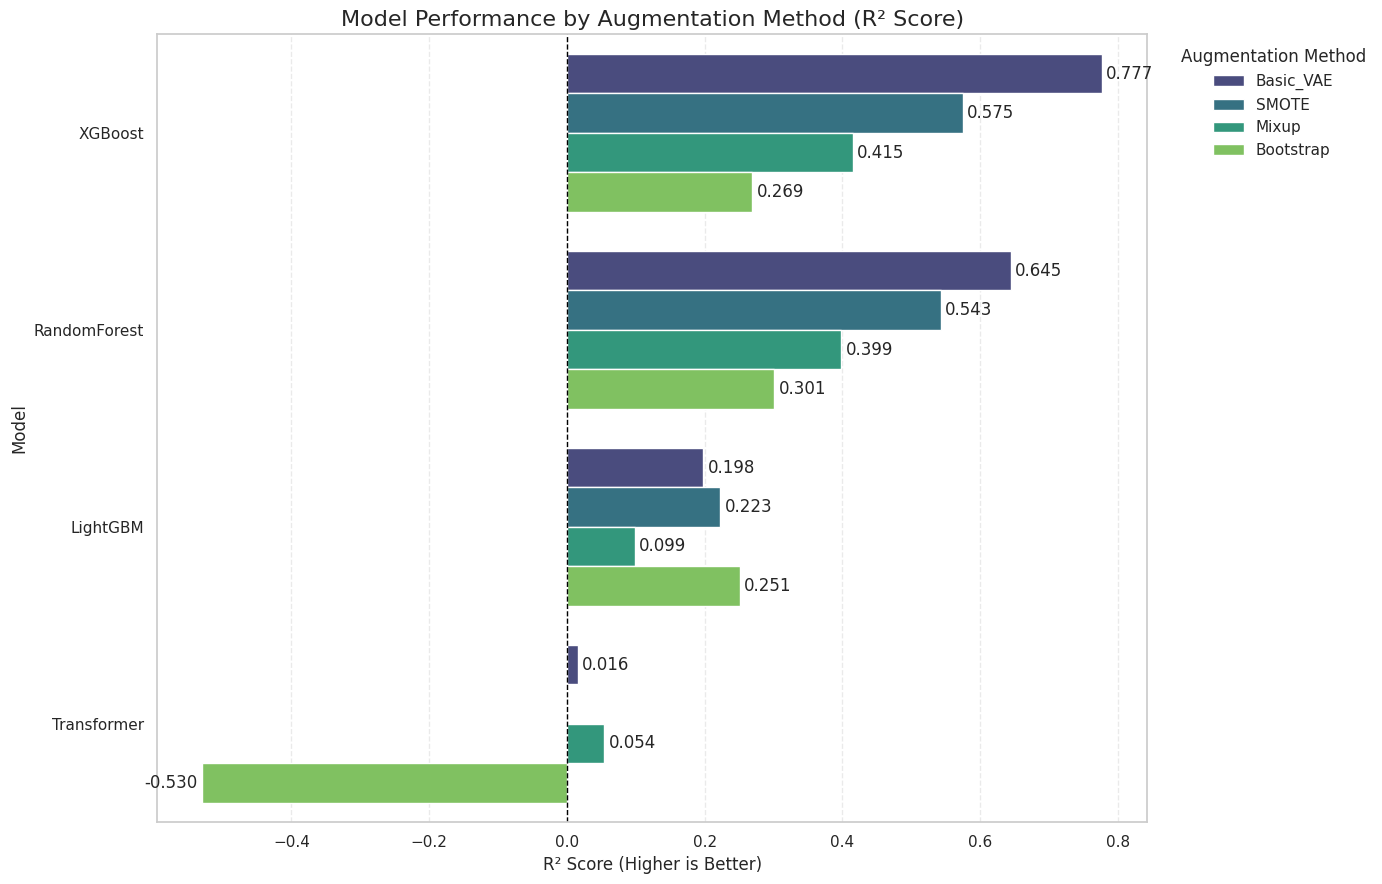

In [57]:
# ==============================
# 6. Results Visualization (Improved)
# ==============================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort results
results_sorted = results_df.sort_values("R2", ascending=False)

# Optional: keep only top 15 results for clarity
top_n = 15
results_top = results_sorted.head(top_n)

plt.figure(figsize=(14, 9))

ax = sns.barplot(
    x="R2",
    y="Model",
    hue="Augmentation",
    data=results_top,
    palette="viridis",
    orient="h"
)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=3)

plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.title("Model Performance by Augmentation Method (R² Score)", fontsize=16)
plt.xlabel("R² Score (Higher is Better)", fontsize=12)
plt.ylabel("Model", fontsize=12)

plt.legend(title="Augmentation Method", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("model_performance.png", dpi=300, bbox_inches="tight")

print("\n📊 Improved model performance visualization saved as 'model_performance.png'")

plt.show()